#   Mass-spring experiment using HNN

In this tutorial, we will be using Hamiltoninan Neural Networks(HNN) to model the dynamics of a simple mass-spring system. The goal is to show how HNNs can learn the underlying physics of a system rather than just fitting data like a typical neural network.


## Colab

# Introduction to Hamiltonian mechanics
In classical mechanics, we often describe a physical system using phase space coordinates, which are just:

* `q`: position
* `p`: momentum  

Together, they define the state of the system at any time.
Now, instead of working with forces (like in Newton's laws), Hamiltonian mechanics gives us a different approach. It describes how `q` and `p` evolve over time using something called the Hamiltonian — usually representing the total energy of the system (kinetic + potential).
The dynamics are given by these equations:

$$
\frac{dq}{dt} = \frac{\partial H}{\partial p}, \quad \frac{dp}{dt} = -\frac{\partial H}{\partial q}
$$





# HNN vs Traditional Neural Networks



<p align="center">
  <img src="https://greydanus.github.io/assets/hamiltonian-nns/overall-idea.png" width="800"/>
</p>

<p align="center">
  <em>Figure: Overall idea of Hamiltonian Neural Networks. Source: <a href="#Bibliography">[4]</a></em>
</p>

Neural networks are good at fitting data, but they often ignore the underlying physics of the system. Hamiltonian Neural Networks (HNNs) take a different approach — instead of predicting the next state directly, they learn the system's Hamiltonian and use it to generate dynamics.

HNNs work by learning a scalar-valued function H(q, p), which represents the total energy (Hamiltonian) of the system. Once trained, the network outputs this Hamiltonian, and we use Hamilton's equations to compute how position and momentum evolve over time.

To get these dynamics, we use a structure called the symplectic gradient. For H(q, p), the time derivatives of position and momentum are computed using:
$$
\frac{d}{dt}
\begin{bmatrix}
q \\
p
\end{bmatrix}
=
\begin{bmatrix}
\frac{\partial H}{\partial p} \\
- \frac{\partial H}{\partial q}
\end{bmatrix}
$$

This operation is often written using a symplectic matrix J:
$$
\frac{dz}{dt} = J \nabla_z H(z)
\quad \text{where} \quad
z =
\begin{bmatrix}
q \\
p
\end{bmatrix},
\quad
J =
\begin{bmatrix}
0 & 1 \\
-1 & 0
\end{bmatrix}
$$


# The mass-spring experiment

We are simulating HNN on a experiment such as mass-spring system

<p align="center">
  <img src="https://i.ytimg.com/vi/lZPtFDXYQRU/maxresdefault.jpg" width="800"/>
</p>
<p align="center">
  <em>Figure: Mass-spring system illustration. Source: <a href="#Bibliography">[5]</a></em>
</p>

In simple terms, the object is attached to a spring, we denote co-ordinates of object on basis of its position `q` and its momentum `p`, Initially both the (q, p) values are zero, so we slightly push the object to simulate the experiment.

The equation is stated as :
$$
H(q, p) = \frac{1}{2}p^2 + \frac{1}{2}q^2
$$

- The term $\frac{1}{2}p^2$ represents the **kinetic energy** of the system.  
- The term $\frac{1}{2}q^2$ represents the **potential energy** stored in the spring.  
- The total energy, represented by the Hamiltonian $H$, remains **constant** throughout the motion.

Now, lets start with the dataset for mass-spring experiment.



In [1]:
# Hamiltonian Neural Networks | 2019
# Sam Greydanus, Misko Dzamba, Jason Yosinski

import autograd
import autograd.numpy as np

import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

def hamiltonian_fn(coords):
    q, p = np.split(coords,2)
    H = p**2 + q**2 # spring hamiltonian (linear oscillator)
    return H

def dynamics_fn(t, coords):
    dcoords = autograd.grad(hamiltonian_fn)(coords)
    dqdt, dpdt = np.split(dcoords,2)
    S = np.concatenate([dpdt, -dqdt], axis=-1)
    return S

def get_trajectory(t_span=[0,3], timescale=10, radius=None, y0=None, noise_std=0.1, **kwargs):
    t_eval = np.linspace(t_span[0], t_span[1], int(timescale*(t_span[1]-t_span[0])))

    # get initial state
    if y0 is None:
        y0 = np.random.rand(2)*2-1
    if radius is None:
        radius = np.random.rand()*0.9 + 0.1 # sample a range of radii
    y0 = y0 / np.sqrt((y0**2).sum()) * radius ## set the appropriate radius

    spring_ivp = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-10, **kwargs)
    q, p = spring_ivp['y'][0], spring_ivp['y'][1]
    dydt = [dynamics_fn(None, y) for y in spring_ivp['y'].T]
    dydt = np.stack(dydt).T
    dqdt, dpdt = np.split(dydt,2)

    # add noise
    q += np.random.randn(*q.shape)*noise_std
    p += np.random.randn(*p.shape)*noise_std
    return q, p, dqdt, dpdt, t_eval

def get_dataset(seed=0, samples=50, test_split=0.5, **kwargs):
    data = {'meta': locals()}

    # randomly sample inputs
    np.random.seed(seed)
    xs, dxs = [], []
    for s in range(samples):
        x, y, dx, dy, t = get_trajectory(**kwargs)
        xs.append( np.stack( [x, y]).T )
        dxs.append( np.stack( [dx, dy]).T )

    data['x'] = np.concatenate(xs)
    data['dx'] = np.concatenate(dxs).squeeze()

    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

def get_field(xmin=-1.2, xmax=1.2, ymin=-1.2, ymax=1.2, gridsize=20):
    field = {'meta': locals()}

    # meshgrid to get vector field
    b, a = np.meshgrid(np.linspace(xmin, xmax, gridsize), np.linspace(ymin, ymax, gridsize))
    ys = np.stack([b.flatten(), a.flatten()])

    # get vector directions
    dydt = [dynamics_fn(None, y) for y in ys.T]
    dydt = np.stack(dydt).T

    field['x'] = ys.T
    field['dx'] = dydt.T
    return field

# Explanation of Dataset script

The author of HNN paper has also provided scritps to generate synthetic dataset for each of the experiments, so we are here using it, the explanation is as follows:

### 1. hamiltonian_fn
* This methods defines/implements the main equation of hamiltonian mechanics for mass-spring experiment.
* Here, the mass `m` is assumed as 1 and spiring constant `k` is also assumed as 1 that's why the final equation is: $$H(q, p) = q^2 + p^2$$

### 2. dynamics_fn
* This computes the time derivative of coordinates `(q, p)` using the `hamiltonian_fn` to get correct "Ground Truth" values.
* Also constructs the Symplectic gradient (S) by calculating `dqdt` and `dpdt` :
$$
\frac{dq}{dt} = \frac{\partial H}{\partial p}, \quad \frac{dp}{dt} = -\frac{\partial H}{\partial q}
$$


### 3. get_trajectory

* Simulates the true dynamics of the system using numerical integration.

### 4. get_dataset

*  Generates a full dataset by calling `get_trajectory` multiple times.
* it contains `x` : state vectors and `dx` : their derivatives


### 5. get_field
* Creates a grid in phase space (q vs p)
* Computes `dynamics_fn` for each grid point


Now lets explore our dataset.

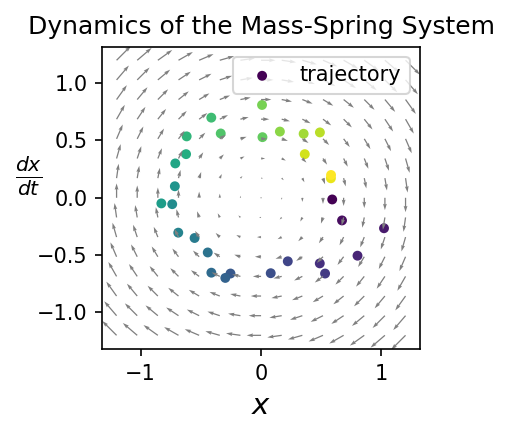

In [2]:
import matplotlib.pyplot as plt

field = get_field(gridsize=15)
data = get_dataset()

# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white', dpi=150)

x, y, dx, dy, t = get_trajectory(radius=0.7, y0=np.array([1, 0]))
plt.scatter(x, y, c=t, s=14, label='trajectory')
plt.quiver(field['x'][:, 0], field['x'][:, 1], field['dx'][:, 0], field['dx'][:, 1],
           cmap='gray_r', color=(.5, .5, .5))

plt.xlabel("$x$", fontsize=14)
plt.ylabel(r"$\frac{dx}{dt}$", rotation=0, fontsize=14)
plt.title("Dynamics of the Mass-Spring System")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


Now lets load the HNN model and fit our dataset and fit on our dataset

In [3]:
!pip install -q deepchem
import deepchem
deepchem.__version__

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


'2.8.1.dev'

In [5]:
from deepchem.data import NumpyDataset

train_dataset = NumpyDataset(X=data['x'], y=data['dx'])
test_dataset = NumpyDataset(X=data['test_x'], y=data['test_dx'])

In [6]:
from deepchem.models.torch_models.hnn import HNN, HNNModel

model = HNNModel(batch_size=64)

In [7]:
model.fit(train_dataset, nb_epoch=100)

0.04196084499359131

In [11]:
H_pred = model.predict(test_dataset)


print(test_dataset.y[:1])
print(H_pred[:1])

[[-0.3033807   1.46951042]]
[[-0.30253646  1.7222674 ]]


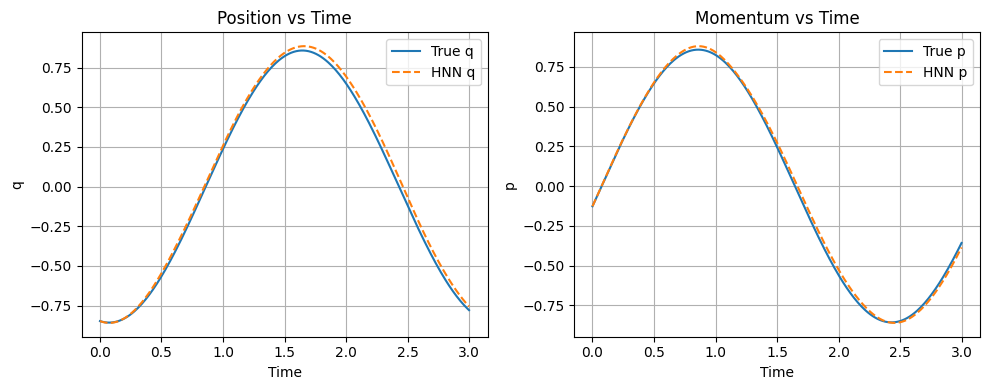

In [16]:
import matplotlib.pyplot as plt
import torch

def learned_dynamics(t, y):
    y_tensor = torch.tensor(y, dtype=torch.float32, requires_grad=True).unsqueeze(0)
    dydt = model.symplectic_gradient(y_tensor).squeeze().detach().numpy()
    return dydt


y0 = test_dataset.X[0]
t_span = [0, 3]
t_eval = np.linspace(*t_span, 300)

# Ground truth trajectory
gt_ivp = solve_ivp(dynamics_fn, t_span, y0, t_eval=t_eval)

# Learned HNN trajectory
learned_ivp = solve_ivp(learned_dynamics, t_span, y0, t_eval=t_eval)


t = t_eval  # time steps
q_true, p_true = gt_ivp.y
q_pred, p_pred = learned_ivp.y

# Plot q(t)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(t, q_true, label='True q')
plt.plot(t, q_pred, '--', label='HNN q')
plt.xlabel('Time')
plt.ylabel('q')
plt.title('Position vs Time')
plt.legend()
plt.grid(True)

# Plot p(t)
plt.subplot(1, 2, 2)
plt.plot(t, p_true, label='True p')
plt.plot(t, p_pred, '--', label='HNN p')
plt.xlabel('Time')
plt.ylabel('p')
plt.title('Momentum vs Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Discord
The DeepChem [Discord](https://discord.gg/cGzwCdrUqS) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!



# Bibliography

[1] Greydanus, S., Dzamba, M., & Yosinski, J. (2019). *Hamiltonian Neural Networks*. [NeurIPS 2019 Paper](https://arxiv.org/abs/1906.01563)

[2] GitHub Repository – [Hamiltonian Neural Networks](https://github.com/greydanus/hamiltonian-nn)

[3] Greydanus, S. (2019). *Learning Physics with Neural Networks*. Blog post: [https://greydanus.github.io/2019/05/15/hamiltonian-nns/](https://greydanus.github.io/2019/05/15/hamiltonian-nns/)

[4] HNNvsNN Overall Architecture: [https://greydanus.github.io/assets/hamiltonian-nns/overall-idea.png](https://greydanus.github.io/assets/hamiltonian-nns/overall-idea.png)

[5] Mass-spring system image: [https://i.ytimg.com/vi/lZPtFDXYQRU/maxresdefault.jpg](https://i.ytimg.com/vi/lZPtFDXYQRU/maxresdefault.jpg)


## Citing This Tutorial
If you found this tutorial useful please consider citing it using the provided BibTeX. 

In [ ]:
@manual{Intro10, 
 title={Mass-spring experiment using HNN}, 
 organization={DeepChem},
 author={Abhay Shinde,  José A. Sigüenza }, 
 howpublished = {\url{https://github.com/deepchem/deepchem/tree/master/examples/tutorials}}, 
 year={2025}, 
} 